J1:
Swedish: ['Morän', 'Postglacial sand--grus', 'Svallsediment, grus--block', 'Torv', 'Isälvssediment', 'Lera--silt']
Finnish: ['Moreeni', 'Jääkauden jälkeinen hiekka--sora', 'Huuhdottu sedimentti, sora--kivet', 'Turve', 'Sulamisvesisedimentti', 'Savi--lieju']
English: ['Moraine', 'Postglacial sand--gravel', 'Washed sediment, gravel--boulders', 'Peat', 'Glaciofluvial sediment', 'Clay--silt']

J2:
Swedish: ['Fyllning', 'Isälvssediment', 'Torv', 'Postglacial sand', 'Älvsediment, sand', 'Vatten', 'Morän', 'Lera--silt', 'Berg']
Finnish: ['Täyttömaa', 'Sulamisvesisedimentti', 'Turve', 'Jääkauden jälkeinen hiekka', 'Jokisedimentti, hiekka', 'Vesi', 'Moreeni', 'Savi--lieju', 'Kallio']
English: ['Fill', 'Glaciofluvial sediment', 'Peat', 'Postglacial sand', 'Fluvial sediment, sand', 'Water', 'Moraine', 'Clay--silt', 'Bedrock']

J1_J2:
Swedish: [

In [1]:
import tools
import rasterio
import geopandas as gpd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from catchment import stem_volume_to_LAI
from rasterio.fill import fillnodata
from tools import burn_water_dem

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### CATCHMENTS SHAPEFILE DETERMINES THE BOUNDS SUBSET (FROM KRYCKLAN DATABASE)

In [3]:
file = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/CATCHMENTS/Krycklan_catchments/Krycklan catchments.shp'
df = gpd.read_file(file)
subset = df.total_bounds
subset = subset.round(0)
# and 50m buffer
subset[0] = subset[0]-50
subset[1] = subset[1]-50
subset[2] = subset[2]+50
subset[3] = subset[3]+50

### SLU FOREST MAP 2010 (FROM ONLINE)

In [5]:
fd = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SLU_FOREST_MAP/2010/'
out_fd = '/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SLU_FOREST_MAP_KRYCKLAN/2010/'
p = os.path.join(fd, '*.tif')
for file in glob.glob(p):
    out_fn = file.rpartition('/')[-1][:-4]
    out_fp = os.path.join(out_fd, out_fn) + '.asc'
    tools.open_raster_with_subset(file, out_fp, subset, plot=False, save_in='asc')

In [34]:
fd = '/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SLU_FOREST_MAP_KRYCKLAN/2010/'
out_fd = '/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SLU_FOREST_MAP_KRYCKLAN/2010_processed/'
p = os.path.join(fd, '*.asc')
for file in glob.glob(p):
    out_fn = file.rpartition('/')[-1][:-4]
    out_fp = os.path.join(out_fd, out_fn) + '.asc'
    with rasterio.open(file) as src:
        data = src.read(1)
        meta = src.meta.copy()
        nodata_1 = meta['nodata']
        nodata_2 = -9999
        data[data == nodata_1] = nodata_2
        data[data == nodata_2] = 0.0
        meta.update({"nodata":nodata_2})
    with rasterio.open(out_fp, 'w', **meta) as dst:
        src = dst.write(data, 1)

### CANOPY FRACTION AND LAI FRACTIONS FROM FOREST MAP

In [35]:
vol_spruce_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SLU_FOREST_MAP_KRYCKLAN/2010_processed/SPRUCEVOL_XX_P_10.asc'
vol_pine_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SLU_FOREST_MAP_KRYCKLAN/2010_processed/PINEVOL_XX_P_10.asc'
vol_decid_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SLU_FOREST_MAP_KRYCKLAN/2010_processed/DECIDUOUSVOL_XX_P_10.asc'
lai_spruce_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SLU_FOREST_MAP_KRYCKLAN/2010_processed/LAI_FM_spruce.asc'
lai_pine_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SLU_FOREST_MAP_KRYCKLAN/2010_processed/LAI_FM_pine.asc'
lai_decid_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SLU_FOREST_MAP_KRYCKLAN/2010_processed/LAI_FM_decid.asc'

files = [vol_spruce_fp, vol_pine_fp, vol_decid_fp]
out_files = [lai_spruce_fp, lai_pine_fp, lai_decid_fp]
trees = ['spruce', 'pine', 'decid']

for idx, file in enumerate(files):
    with rasterio.open(file) as src:
        vol = src.read(1)
        vol = vol.astype(float)
        out_meta = src.meta.copy()
        nodata = out_meta['nodata']
        vol[vol == nodata] = 0.0
        LAI = stem_volume_to_LAI(vol, tree=trees[idx])
        out_meta.update({"nodata": -9999,
                        "dtype": np.float32,
                        })
        with rasterio.open(out_files[idx], 'w', **out_meta) as dst:
            out = dst.write(LAI, 1)

# MAKE CANOPY FRACTION AS SAMULI PROPOSED

In [38]:
lai_spruce_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SLU_FOREST_MAP_KRYCKLAN/2010_processed/LAI_FM_spruce.asc'
lai_pine_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SLU_FOREST_MAP_KRYCKLAN/2010_processed/LAI_FM_pine.asc'
lai_decid_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SLU_FOREST_MAP_KRYCKLAN/2010_processed/LAI_FM_decid.asc'

laif_spruce_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SLU_FOREST_MAP_KRYCKLAN/2010_processed/LAIF_FM_spruce.asc'
laif_pine_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SLU_FOREST_MAP_KRYCKLAN/2010_processed/LAIF_FM_pine.asc'
laif_decid_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SLU_FOREST_MAP_KRYCKLAN/2010_processed/LAIF_FM_decid.asc'

with rasterio.open(lai_spruce_fp) as src1:
    lai_spruce = src1.read(1)
    out_meta = src1.meta.copy()
    nodata = out_meta['nodata']
with rasterio.open(lai_pine_fp) as src2:
    lai_pine = src2.read(1)
with rasterio.open(lai_decid_fp) as src3:
    lai_decid = src3.read(1)
    lai_tot = lai_spruce + lai_pine + lai_decid
    laif_decid = lai_decid / lai_tot
    laif_spruce = lai_spruce / lai_tot
    laif_pine = lai_pine / lai_tot
    laif_spruce[~np.isfinite(laif_spruce)] = 0
    laif_pine[~np.isfinite(laif_pine)] = 0
    laif_decid[~np.isfinite(laif_decid)] = 0
    
    with rasterio.open(laif_spruce_fp, 'w', **out_meta) as dst1:
        out1 = dst1.write(laif_spruce, 1)
    with rasterio.open(laif_pine_fp, 'w', **out_meta) as dst2:
        out2 = dst2.write(laif_pine, 1)
    with rasterio.open(laif_decid_fp, 'w', **out_meta) as dst3:
        out3 = dst3.write(laif_decid, 1)

/var/folders/01/f14lxpfj5wl28zjtf5rz8t9c0000gn/T/ipykernel_5358/713177211.py:18: RuntimeWarning: invalid value encountered in divide
  laif_decid = lai_decid / lai_tot
/var/folders/01/f14lxpfj5wl28zjtf5rz8t9c0000gn/T/ipykernel_5358/713177211.py:19: RuntimeWarning: invalid value encountered in divide
  laif_spruce = lai_spruce / lai_tot
/var/folders/01/f14lxpfj5wl28zjtf5rz8t9c0000gn/T/ipykernel_5358/713177211.py:20: RuntimeWarning: invalid value encountered in divide
  laif_pine = lai_pine / lai_tot


### LAI (FROM HENRIK)

In [12]:
fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/KRYCKLAN_LAI/LAI_Krycklan_ALS_2019.tif'
out_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/KRYCKLAN_LAI/processed/LAI_Krycklan_ALS_2019_match_forestmap.asc'
match = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SLU_FOREST_MAP_KRYCKLAN/2010/HEIGHT_XX_P_10.asc'
tools.reproj_match(infile=fp, match=match, outfile=out_fp, resampling_method='bilinear', save_in='asc')

Coregistered to shape: 460 412 
 Affine | 24.99, 0.00, 726726.00|
| 0.00,-24.99, 7138700.00|
| 0.00, 0.00, 1.00|


In [41]:
file = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/KRYCKLAN_LAI/processed/LAI_Krycklan_ALS_2019_match_forestmap.asc'
out_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/KRYCKLAN_LAI/processed/LAI_Krycklan_ALS_2019_match_forestmap_nona.asc'

with rasterio.open(file) as src:
    data = src.read(1)
    meta = src.meta.copy()
    nodata_1 = meta['nodata']
    nodata_2 = -9999
    data[data == nodata_1] = nodata_2
    data[data == nodata_2] = 0.0
    data[data < 0] = 0.0
    meta.update({"nodata": nodata_2})
with rasterio.open(out_fp, 'w', **meta) as dst:
    src = dst.write(data, 1)

### LAI FRACTIONS * LAI TOT = LAI SPECIES

In [43]:
fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/KRYCKLAN_LAI/processed/LAI_Krycklan_ALS_2019_match_forestmap_nona.asc'
lai_spruce_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/KRYCKLAN_LAI/processed/LAI_spruce.asc'
lai_pine_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/KRYCKLAN_LAI/processed/LAI_pine.asc'
lai_decid_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/KRYCKLAN_LAI/processed/LAI_decid.asc'

with rasterio.open(fp) as src:
    lai_tot = src.read(1)
    nodata = src.meta.copy()['nodata']
    out_meta = src.meta.copy()
    lai_decid = lai_tot * laif_decid
    lai_spruce = lai_tot * laif_spruce
    lai_pine = lai_tot * laif_pine
    lai_decid[lai_tot == nodata] = nodata
    lai_spruce[lai_tot == nodata] = nodata
    lai_pine[lai_tot == nodata] = nodata
    
    lai_decid[(lai_decid < 0) & (lai_decid != nodata)] = 0
    lai_spruce[(lai_spruce < 0) & (lai_spruce != nodata)] = 0
    lai_pine[(lai_pine < 0) & (lai_pine != nodata)] = 0
    
    with rasterio.open(lai_spruce_fp, 'w', **out_meta) as dst:
        out = dst.write(lai_spruce, 1)
    with rasterio.open(lai_pine_fp, 'w', **out_meta) as dst:
        out = dst.write(lai_pine, 1)
    with rasterio.open(lai_decid_fp, 'w', **out_meta) as dst:
        out = dst.write(lai_decid, 1)

In [17]:
def ba_from_vol(vol, a):
    ba = a * vol
    return ba

def cf_from_ba(ba):
    cf = 0.1939 * ba / (0.1939 * ba + 1.69)
    return cf

In [19]:
vol_spruce_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SLU_FOREST_MAP_KRYCKLAN/2010/SPRUCEVOL_XX_P_10.asc'
vol_pine_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SLU_FOREST_MAP_KRYCKLAN/2010/PINEVOL_XX_P_10.asc'
vol_decid_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SLU_FOREST_MAP_KRYCKLAN/2010/DECIDUOUSVOL_XX_P_10.asc'

cf_out_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SLU_FOREST_MAP_KRYCKLAN/2010_processed/canopy_fraction.asc'

with rasterio.open(vol_spruce_fp) as src:
    vol = src.read(1)
    vol = vol.astype(float)
    out_meta = src.meta.copy()
    nodata = out_meta['nodata']
    vol[vol == nodata] = 0.0
    BA_spruce = ba_from_vol(vol=vol, a=0.09)
with rasterio.open(vol_pine_fp) as src:
    vol = src.read(1)
    vol = vol.astype(float)
    out_meta = src.meta.copy()
    nodata = out_meta['nodata']
    vol[vol == nodata] = 0.0
    BA_pine = ba_from_vol(vol=vol, a=0.12)
with rasterio.open(vol_decid_fp) as src:
    vol = src.read(1)
    vol = vol.astype(float)
    out_meta = src.meta.copy()
    nodata = out_meta['nodata']
    vol[vol == nodata] = 0.0
    BA_decid = ba_from_vol(vol=vol, a=0.12)

    BA_tot = BA_spruce + BA_pine + BA_decid
    
    cf = cf_from_ba(ba=BA_tot)
    
    out_meta.update({"nodata": -9999,
                    "dtype": np.float32,
                    })
with rasterio.open(cf_out_fp, 'w', **out_meta) as dst:
    out = dst.write(cf, 1)

### STREAMS INTO STREAM MASK

In [3]:
file1 = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/CATCHMENTS/Krycklan_5ha_streams/5haStreams.shp'
file2 = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/CATCHMENTS/ManualStreams/ManuallyDigitizedDitchesKrycklan.shp'

out_fp1 = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/DEM/derivatives/stream_5ha_mask.asc'
out_fp2 = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/DEM/derivatives/ditch_manual_mask.asc'

ref_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SLU_FOREST_MAP_KRYCKLAN/2010/BIRCHVOL_XX_P_10.asc'

tools.rasterize_shapefile(shapefile=file1, burn_field='GRID_CODE', subset=None, out_fp=out_fp1, ref_raster=ref_fp, plot=False, save_in='asc')
tools.rasterize_shapefile(shapefile=file2, burn_field='VALUE', subset=None, out_fp=out_fp2, ref_raster=ref_fp, plot=False, save_in='asc')

In [4]:
# combine those two from before
file1 = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/DEM/derivatives/stream_5ha_mask.asc'
file2 = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/DEM/derivatives/ditch_manual_mask.asc'

out_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/DEM/derivatives/stream_ditch_mask.asc'
tools.fill_layer_na_with_layer(priority_layer=file1, secondary_layer=file2, out_fp=out_fp, save_in='asc')

### DEM (FROM KRYCKLAN DATABASE)

In [2]:
fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/DEM/Krycklan_2015_DEM_0.5m/Krycklan_2015_DEM.tif'
out_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/DEM/processed/Krycklan_2015_DEM_match_forestmap.asc'
match = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SLU_FOREST_MAP_KRYCKLAN/2010/HEIGHT_XX_P_10.asc'
tools.reproj_match(infile=fp, match=match, outfile=out_fp, resampling_method='bilinear', save_in='asc')

Coregistered to shape: 460 412 
 Affine | 24.99, 0.00, 726726.00|
| 0.00,-24.99, 7138700.00|
| 0.00, 0.00, 1.00|


In [3]:
# INTERPOLATING HOLES
fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/DEM/processed/Krycklan_2015_DEM_match_forestmap.asc'
with rasterio.open(fp) as src:
    profile = src.profile
    arr = src.read(1)
    arr_filled = fillnodata(arr, mask=src.read_masks(1), max_search_distance=5, smoothing_iterations=0)

out_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/DEM/processed/Krycklan_2015_DEM_match_forestmap_filled.asc' 
with rasterio.open(out_fp, 'w', **profile) as dest:
    dest.write_band(1, arr_filled)

### DEM BURN WATER

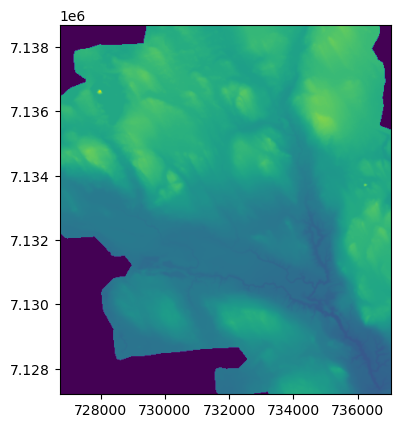

In [6]:
stream = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/DEM/derivatives/stream_ditch_mask.asc'
lake_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SOIL/krycklan_QD/lake_mask.asc'
dem_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/DEM/processed/Krycklan_2015_DEM_match_forestmap_filled.tif' 

fdem, out_fp = burn_water_dem(dem_fp=dem_fp, stream_fp=stream, lake_fp=None)

### DEM DERIVATIVES WITH PYSHEDS

In [7]:
dem_path = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/DEM/processed/Krycklan_2015_DEM_match_forestmap_filled_burned_streams.asc'
out_fd = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/DEM/derivatives/'
tools.dem_derivatives(dem_path=dem_path, out_fd=out_fd, routing='d8')

/Users/jpnousu/SpaFHy_GISPUTS/tools.py:1049: RuntimeWarning: invalid value encountered in log
  twi = np.log((acc+1) / (np.tan(slope) + eps))


### SOIL MAP (FROM ANNELI)

In [2]:
file1= r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SOIL/krycklan_QD/krycklan_QD_J1.shp'
file2 = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SOIL/krycklan_QD/krycklan_QD_J2.shp'
df1 = gpd.read_file(file1)
df2 = gpd.read_file(file2)
codes = {}
for id in df1['JY1'].unique():
    codes[id] = df1.loc[df1['JY1'] == id, 'JY1_TX'].iloc[0]
for id in df2['JG2'].unique():
    codes[id] = df2.loc[df2['JG2'] == id, 'JG2_TX'].iloc[0]
print(codes)

{100: 'Morän', 84: 'Postglacial sand--grus', 89: 'Svallsediment, grus--block', 75: 'Torv', 50: 'Isälvssediment', 86: 'Lera--silt', 200: 'Fyllning', 31: 'Postglacial sand', 8809: 'Älvsediment, sand', 91: 'Vatten', 888: 'Berg'}


/Users/jpnousu/miniconda3/envs/pysheds/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: /Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SOIL/krycklan_QD/krycklan_QD_J2.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  result = ogr_read(


In [6]:
file1 = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SOIL/krycklan_QD/krycklan_QD_J1.shp'
file2 = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SOIL/krycklan_QD/krycklan_QD_J2.shp'
out_fp1 = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SOIL/krycklan_QD/krycklan_QD_J1.asc'
out_fp2 = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SOIL/krycklan_QD/krycklan_QD_J2.asc'
ref_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SLU_FOREST_MAP_KRYCKLAN/2010/BIRCHVOL_XX_P_10.asc'
tools.rasterize_shapefile(shapefile=file1, burn_field='JY1', subset=None, out_fp=out_fp1, ref_raster=ref_fp, plot=False, save_in='asc')
tools.rasterize_shapefile(shapefile=file2, burn_field='JG2', subset=None, out_fp=out_fp2, ref_raster=ref_fp, plot=False, save_in='asc')

/Users/jpnousu/miniconda3/envs/pysheds/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: /Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SOIL/krycklan_QD/krycklan_QD_J2.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  result = ogr_read(


In [7]:
file1 = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SOIL/krycklan_QD/krycklan_QD_J1.asc'
file2 = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SOIL/krycklan_QD/krycklan_QD_J2.asc'
out_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SOIL/krycklan_QD/krycklan_QD_J1_J2.asc'
tools.fill_layer_na_with_layer(priority_layer=file1, secondary_layer=file2, out_fp=out_fp, save_in='asc')

In [44]:
file = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SOIL/krycklan_QD/krycklan_QD_J1_J2.asc'
out_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SOIL/krycklan_QD/lake_mask.asc'

with rasterio.open(file) as src:
    data = src.read(1)
    meta = src.meta.copy()
    new_data = data.copy()
    new_data[data != 91.0] = meta['nodata']
    new_data[data == 91.0] = 1.0
with rasterio.open(out_fp, 'w', **meta) as dst:
    out = dst.write(new_data, 1)

In [30]:
file = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SOIL/krycklan_QD/krycklan_QD_J1_J2.asc'
out_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SOIL/krycklan_QD/krycklan_QD_J1_J2_final.asc'

with rasterio.open(file) as src:
    data = src.read(1)
    new_data = data.copy()
    meta = src.meta.copy()
    nodata = meta['nodata']
    orig_uniq = np.unique(data[data != nodata])
    new_uniq = np.arange(1, len(orig_uniq)+1)
    for i in range(len(orig_uniq)):
        new_data[data == orig_uniq[i]] = new_uniq[i] 
with rasterio.open(out_fp, 'w', **meta) as dst:
    out = dst.write(new_data, 1)

### CATCHMENT BOUNDARIES INTO CMASK

In [5]:
file = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/CATCHMENTS/Krycklan_catchments/Krycklan catchments.shp'
out_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/DEM/derivatives/cmask.asc'
ref_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SLU_FOREST_MAP_KRYCKLAN/2010/BIRCHVOL_XX_P_10.asc'
tools.rasterize_shapefile(shapefile=file, burn_field='Huvudomr', subset=None, out_fp=out_fp, ref_raster=ref_fp, plot=False, save_in='asc')